In [1]:
import torch
from esn import ESN
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

## Make sure that my model looks OK

### High g, chaotic

Initializing network with 400 hidden neurons, spectral radius of 1.3, 1 input neurons, 1 output neurons
Maximum eigenvalue of initialized weight matrix: 8.55385684967041
Maximum eigenvalue of scaled weight matrix: 1.2999999523162842


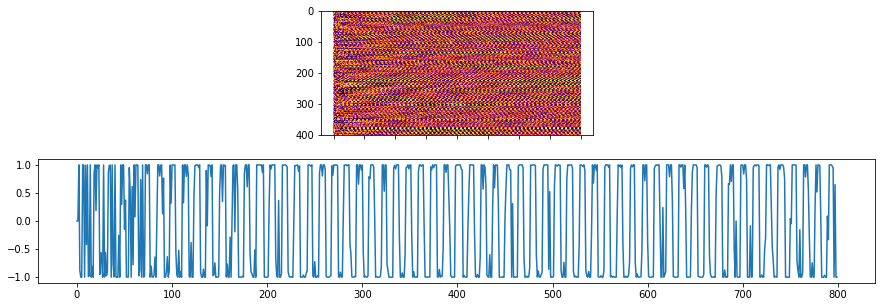

In [2]:
net = ESN(n=400,p=.5,g=1.3,in_scale=0.,fb_scale=0,noise_scale=1e-10)
net.run(steps=800)
net.plot_history()

### Low g, dampening

Initializing network with 400 hidden neurons, spectral radius of 0.99, 1 input neurons, 1 output neurons
Maximum eigenvalue of initialized weight matrix: 8.497580528259277
Maximum eigenvalue of scaled weight matrix: 0.9900000095367432


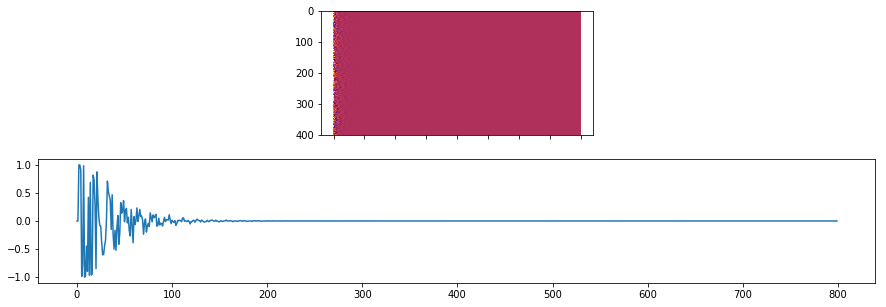

In [3]:
net = ESN(n=400,p=.5,g=.99,in_scale=0.,fb_scale=0,noise_scale=1e-10)
net.run(steps=800)
net.plot_history()

### Turn up the feedback weights to full scale

Initializing network with 400 hidden neurons, spectral radius of 0.99, 1 input neurons, 1 output neurons
Maximum eigenvalue of initialized weight matrix: 8.385862350463867
Maximum eigenvalue of scaled weight matrix: 0.9899999499320984


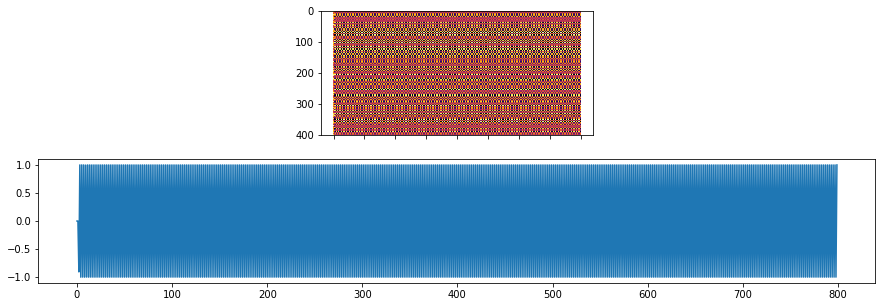

In [4]:
net = ESN(n=400,p=.5,g=.99,in_scale=0.,fb_scale=1,noise_scale=1e-10)
net.run(steps=800)
net.plot_history()

### Lower them

Initializing network with 400 hidden neurons, spectral radius of 0.99, 1 input neurons, 1 output neurons
Maximum eigenvalue of initialized weight matrix: 8.355298042297363
Maximum eigenvalue of scaled weight matrix: 0.9900000095367432


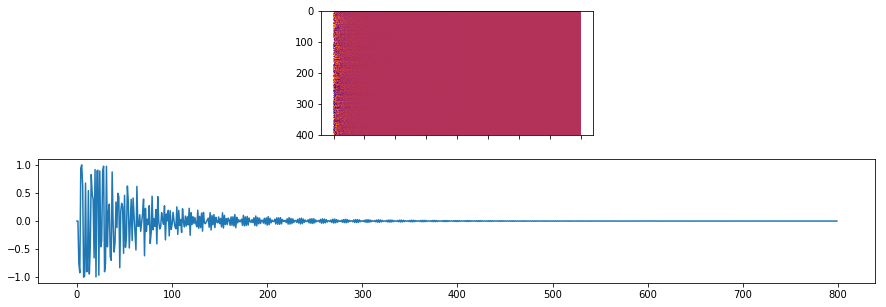

In [5]:
net = ESN(n=400,p=.5,g=.99,in_scale=0.,fb_scale=.001,noise_scale=1e-10)
net.run(steps=800)
net.plot_history()

### Does input work?

Initializing network with 400 hidden neurons, spectral radius of 0.99, 1 input neurons, 1 output neurons
Maximum eigenvalue of initialized weight matrix: 8.916997909545898
Maximum eigenvalue of scaled weight matrix: 0.9900000095367432


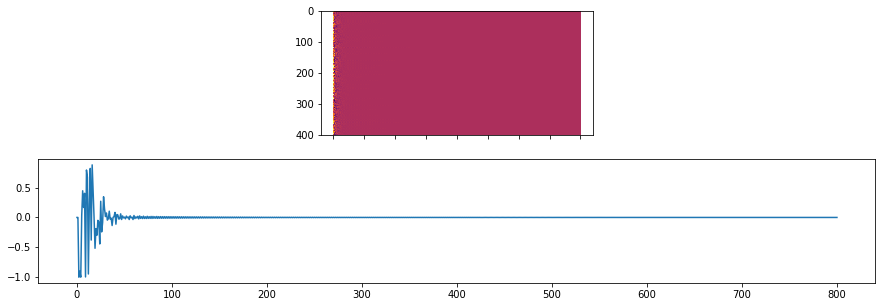

In [6]:
net = ESN(n=400,p=.5,g=.99,in_scale=0.,fb_scale=.001,noise_scale=1e-10)
net.run(steps=400)
net.forward(u=torch.tensor([100.]))
net.run(400)
net.plot_history()

Initializing network with 400 hidden neurons, spectral radius of 0.99, 1 input neurons, 1 output neurons
Maximum eigenvalue of initialized weight matrix: 8.253971099853516
Maximum eigenvalue of scaled weight matrix: 0.9900000095367432


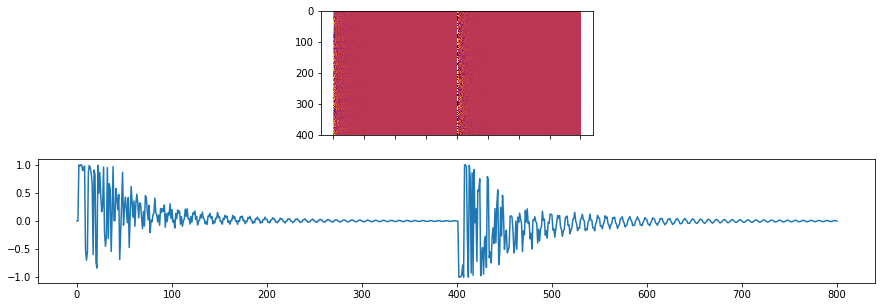

In [7]:
net = ESN(n=400,p=.5,g=.99,in_scale=1,fb_scale=.001,noise_scale=1e-10)
net.run(steps=400)
net.forward(u=torch.tensor([100.]))
net.run(400)
net.plot_history()

# Training time

Initializing network with 400 hidden neurons, spectral radius of 0.8, 1 input neurons, 1 output neurons
Maximum eigenvalue of initialized weight matrix: 1.2247265577316284
Maximum eigenvalue of scaled weight matrix: 0.800000011920929


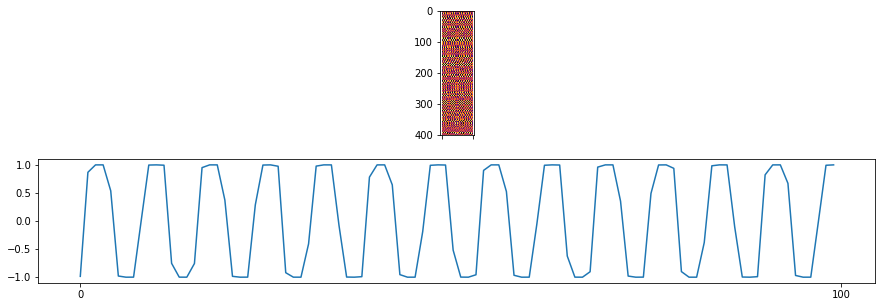

Final MSE: 0.03687013313174248


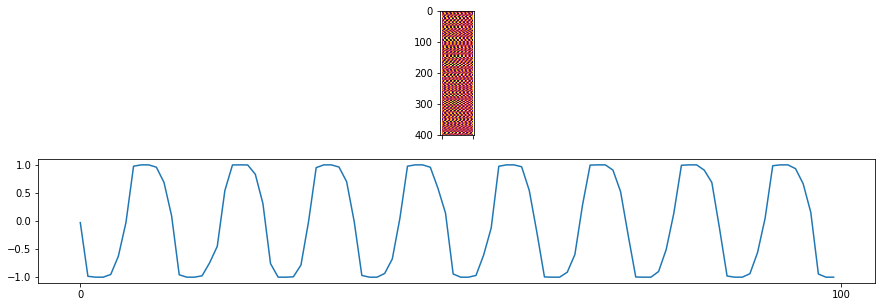

In [8]:
dt = 0.05
warmup_steps = 1000
train_steps = 10000

# Initialize network
net = ESN(n=400,p=.01,g=.8,in_scale=1,fb_scale=1,noise_scale=1e-2)

# Let the network warmup
net.run(warmup_steps)

net.plot_history(start=900,end=1000)

net.x_agg = []
net.y_agg = []
# Start forcing output to be teacher signal
for train_step in range(train_steps):
    net.y = net.nl(torch.sin(torch.tensor([train_step*dt])))
    net.forward(u = torch.tensor([0.2]))


# Train readout weights on that epoch
epochs = 200
lr = 0.01
states = torch.tensor(net.x_agg[:])
targets = torch.tensor(net.y_agg[:])

w_out = (net.w_out).clone().detach().requires_grad_(True)

for epoch in range(1,epochs):
    w_out.grad = None

    net_out = torch.matmul(states,w_out)
    diff = net_out - targets
    sq_err = diff.pow(2)

    mse = torch.sum(sq_err) / train_steps
    
    mse.backward()

    w_out = (w_out - (lr * w_out.grad)).clone().detach().requires_grad_(True)
    


print('Final MSE: {}'.format(mse.data))
net.w_out = w_out
net.x_agg = []
net.y_agg = []
net.run(1000)
net.plot_history(start=900,end=1000)



### Here is the issue: First plot is random initialization. Second is after traning. yes after training we have oscillations, but we also had periodic activity prior to training on this initializatin. So the key thing to look at is the transition from training (where y == target) to the spontaneous activity. My plot_history function actually made some of the stuff you added in the code unnecessary, so I will revert that and give you an example of how to use it.

In [30]:
dt = 0.05
warmup_steps = 100
train_steps = 1000

# Initialize network
net = ESN(n=400,p=.01,g=.8,in_scale=1,fb_scale=1,noise_scale=1e-2)

# Let the network warmup
net.run(warmup_steps)


# Start forcing output to be teacher signal
for train_step in range(train_steps):
    net.y = net.nl(torch.sin(torch.tensor([train_step*dt])))
    net.forward(u = torch.tensor([0.2]))
net.y = net.nl(torch.sin(torch.tensor([(train_step+1)*dt])))

# Train readout weights on that epoch
epochs = 200
lr = 0.01

train_start = warmup_steps+100
train_end = warmup_steps+train_steps

states = torch.tensor(net.x_agg[train_start:train_end])
targets = torch.tensor(net.y_agg[train_start:train_end])

w_out = (net.w_out).clone().detach().requires_grad_(True)

for epoch in range(1,epochs):
    w_out.grad = None

    net_out = torch.matmul(states,w_out)
    diff = net_out - targets
    sq_err = diff.pow(2)

    mse = torch.sum(sq_err) / train_steps
    
    mse.backward()

    w_out = (w_out - (lr * w_out.grad)).clone().detach().requires_grad_(True)
    


print('Final MSE: {}'.format(mse.data))
net.w_out = w_out

net.run(100)




Initializing network with 400 hidden neurons, spectral radius of 0.8, 1 input neurons, 1 output neurons
Maximum eigenvalue of initialized weight matrix: 1.17732572555542
Maximum eigenvalue of scaled weight matrix: 0.7999999523162842
Final MSE: 0.04925179108977318


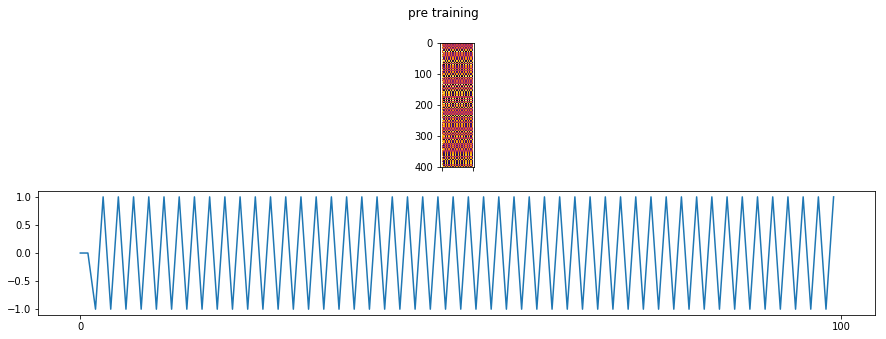

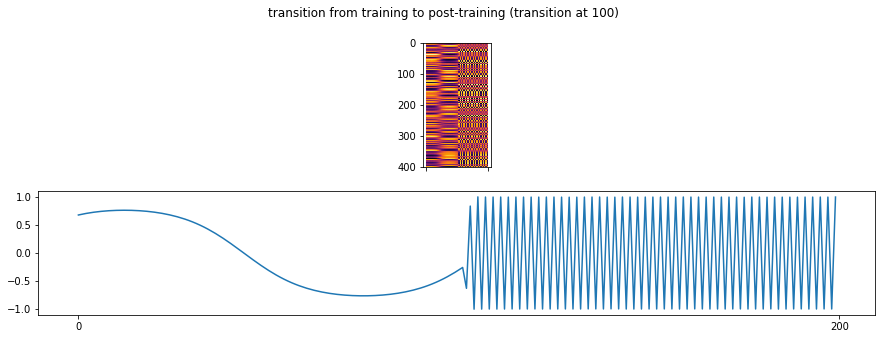

In [32]:
net.plot_history(start=0,end=100,title='pre training')
net.plot_history(start=(train_end-100),end=(train_end+100),title='transition from training to post-training (transition at 100)') 

# So here the oscillatory activity is real, but has nothing to do with the training. 

### Playing with hyperparamters, it seems to work with smaller network sizes and less crazy long timescales

Initializing network with 30 hidden neurons, spectral radius of 0.9, 1 input neurons, 1 output neurons
Maximum eigenvalue of initialized weight matrix: 1.6269036531448364
Maximum eigenvalue of scaled weight matrix: 0.9000000357627869


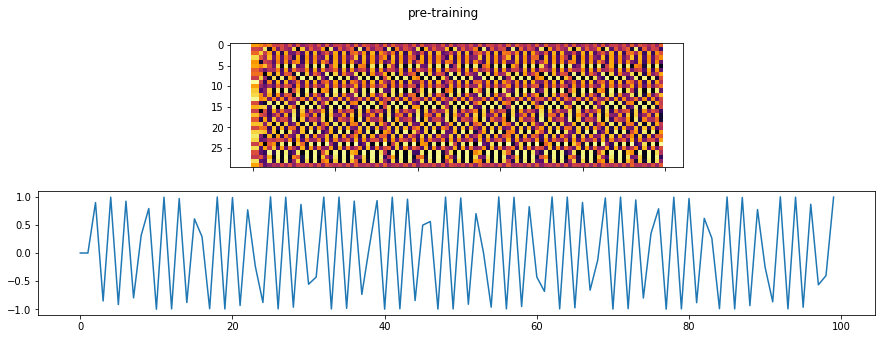

Final MSE: 0.0008031779434531927


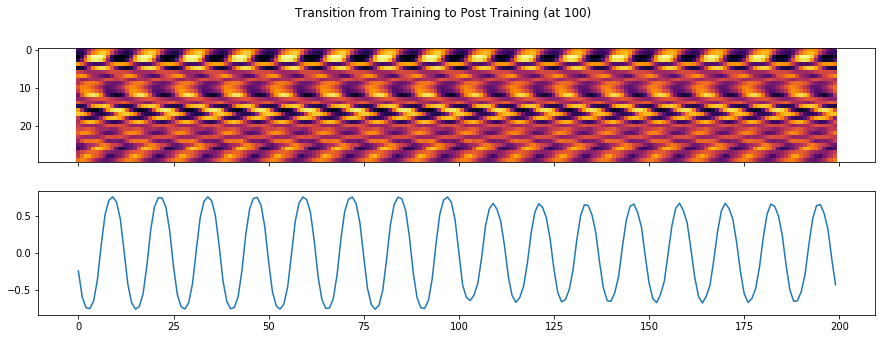

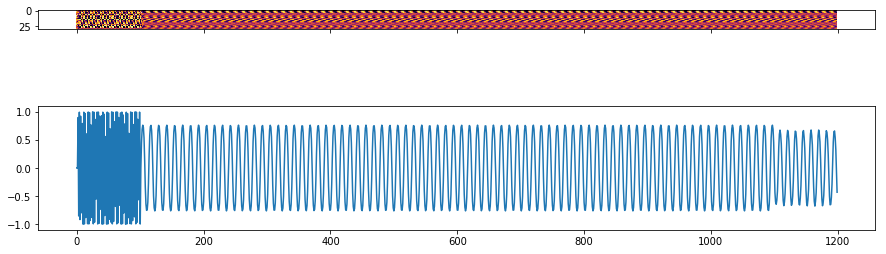

In [43]:
torch.manual_seed(1)

dt = 0.5
warmup_steps = 100
train_steps = 1000

# Initialize network
net = ESN(n=30,p=.3,g=.9,in_scale=1,fb_scale=1,noise_scale=0)

# Let the network warmup
net.run(warmup_steps)

net.plot_history(start=0,end=warmup_steps,title='pre-training')


# Start forcing output to be teacher signal
for train_step in range(train_steps):
    net.y = net.nl(torch.sin(torch.tensor([train_step*dt])))
    net.forward(u = torch.tensor([0.0]))

net.y = net.nl(torch.sin(torch.tensor([(train_step+1)*dt])))


# Train readout weights on that epoch
epochs = 2000
lr = 0.01

train_start = warmup_steps+100
train_end = warmup_steps+train_steps

states = torch.tensor(net.x_agg[train_start:train_end])
targets = torch.tensor(net.y_agg[train_start:train_end])

w_out = (net.w_out).clone().detach().requires_grad_(True)

for epoch in range(1,epochs):
    w_out.grad = None

    net_out = torch.matmul(states,w_out)
    diff = net_out - targets
    sq_err = diff.pow(2)

    mse = torch.sum(sq_err) / train_steps
    
    mse.backward()

    w_out = (w_out - (lr * w_out.grad)).clone().detach().requires_grad_(True)
    


print('Final MSE: {}'.format(mse.data))
net.w_out = w_out

net.run(100)

net.plot_history(start=(train_end-100),end=(train_end+100),title='Transition from Training to Post Training (at 100)') 
net.plot_history()

### Just fails to capture longer-term dynamics

Initializing network with 150 hidden neurons, spectral radius of 0.5, 1 input neurons, 1 output neurons
Maximum eigenvalue of initialized weight matrix: 2.2153117656707764
Maximum eigenvalue of scaled weight matrix: 0.5


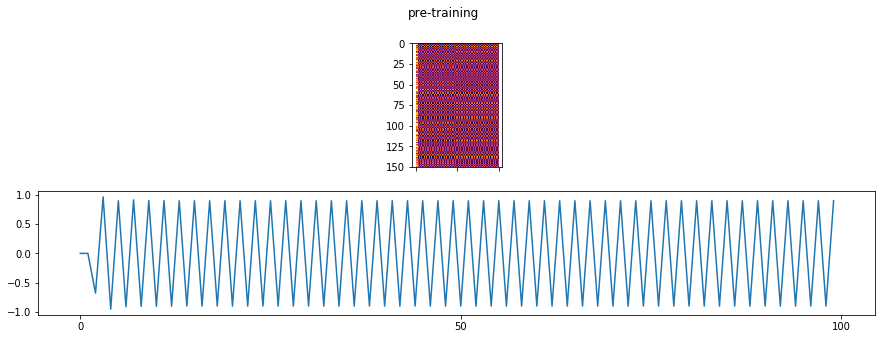

Final MSE: 0.000525707146152854


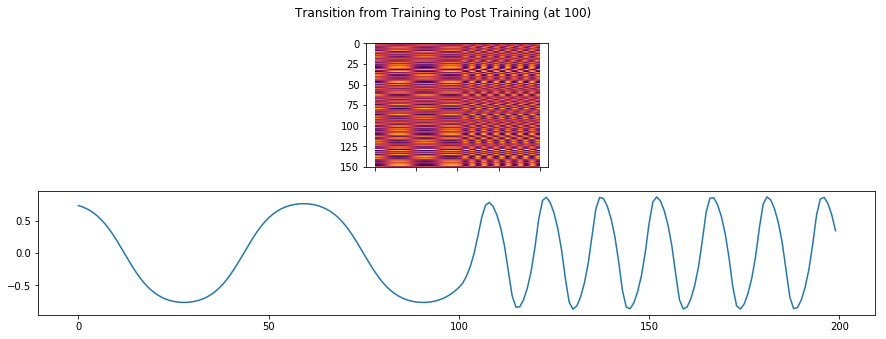

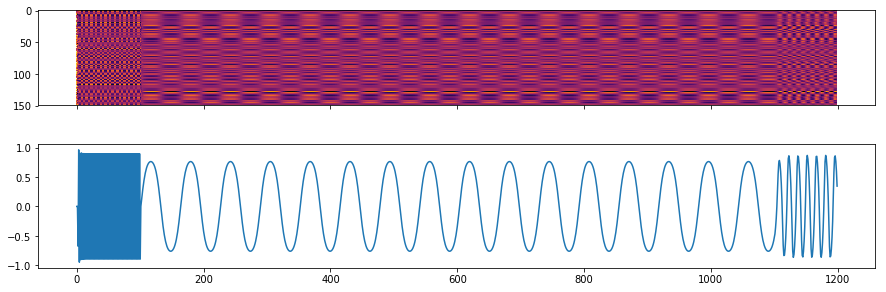

In [40]:
torch.manual_seed(1)

dt = 0.1
warmup_steps = 100
train_steps = 1000

# Initialize network
net = ESN(n=150,p=.1,g=.5,in_scale=1,fb_scale=.5,noise_scale=0)

# Let the network warmup
net.run(warmup_steps)

net.plot_history(start=0,end=warmup_steps,title='pre-training')


# Start forcing output to be teacher signal
for train_step in range(train_steps):
    net.y = net.nl(torch.sin(torch.tensor([train_step*dt])))
    net.forward(u = torch.tensor([0.0]))

net.y = net.nl(torch.sin(torch.tensor([(train_step+1)*dt])))


# Train readout weights on that epoch
epochs = 2000
lr = 0.01

train_start = warmup_steps+100
train_end = warmup_steps+train_steps

states = torch.tensor(net.x_agg[train_start:train_end])
targets = torch.tensor(net.y_agg[train_start:train_end])

w_out = (net.w_out).clone().detach().requires_grad_(True)

for epoch in range(1,epochs):
    w_out.grad = None

    net_out = torch.matmul(states,w_out)
    diff = net_out - targets
    sq_err = diff.pow(2)

    mse = torch.sum(sq_err) / train_steps
    
    mse.backward()

    w_out = (w_out - (lr * w_out.grad)).clone().detach().requires_grad_(True)
    


print('Final MSE: {}'.format(mse.data))
net.w_out = w_out

net.run(100)

net.plot_history(start=(train_end-100),end=(train_end+100),title='Transition from Training to Post Training (at 100)') 
net.plot_history()

### More neurons, same timescale as first:

Initializing network with 100 hidden neurons, spectral radius of 0.92, 1 input neurons, 1 output neurons
Maximum eigenvalue of initialized weight matrix: 2.0959293842315674
Maximum eigenvalue of scaled weight matrix: 0.9200000166893005


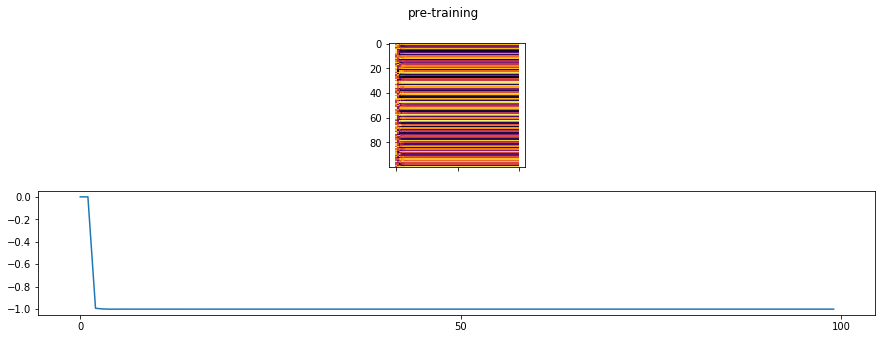

Final MSE: 0.001315426779910922


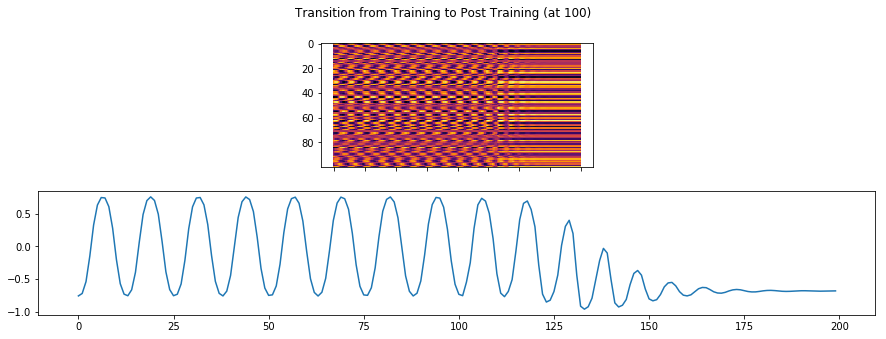

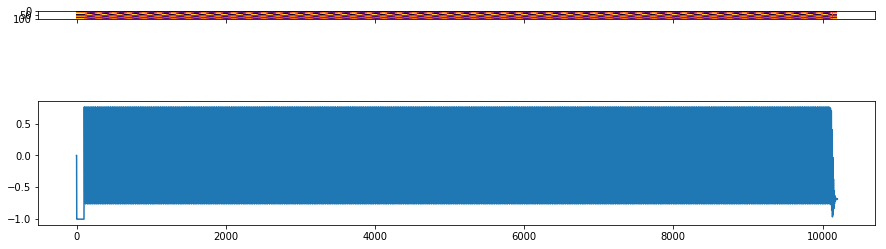

In [52]:
torch.manual_seed(1)

dt = 0.5
warmup_steps = 100
train_steps = 10000

# Initialize network
net = ESN(n=100,p=.1,g=.92,in_scale=1,fb_scale=1,noise_scale=0)

# Let the network warmup
net.run(warmup_steps)

net.plot_history(start=0,end=warmup_steps,title='pre-training')


# Start forcing output to be teacher signal
for train_step in range(train_steps):
    net.y = net.nl(torch.sin(torch.tensor([train_step*dt])))
    net.forward(u = torch.tensor([0.0]))

net.y = net.nl(torch.sin(torch.tensor([(train_step+1)*dt])))


# Train readout weights on that epoch
epochs = 2000
lr = 0.01

train_start = warmup_steps+100
train_end = warmup_steps+train_steps

states = torch.tensor(net.x_agg[train_start:train_end])
targets = torch.tensor(net.y_agg[train_start:train_end])

w_out = (net.w_out).clone().detach().requires_grad_(True)

for epoch in range(1,epochs):
    w_out.grad = None

    net_out = torch.matmul(states,w_out)
    diff = net_out - targets
    sq_err = diff.pow(2)

    mse = torch.sum(sq_err) / train_steps
    
    mse.backward()

    w_out = (w_out - (lr * w_out.grad)).clone().detach().requires_grad_(True)
    


print('Final MSE: {}'.format(mse.data))
net.w_out = w_out

net.run(100)

net.plot_history(start=(train_end-100),end=(train_end+100),title='Transition from Training to Post Training (at 100)') 
net.plot_history()

### Try moore penrose pseudoinverse regression solution

Initializing network with 30 hidden neurons, spectral radius of 0.9, 1 input neurons, 1 output neurons
Maximum eigenvalue of initialized weight matrix: 1.6269036531448364
Maximum eigenvalue of scaled weight matrix: 0.9000000357627869


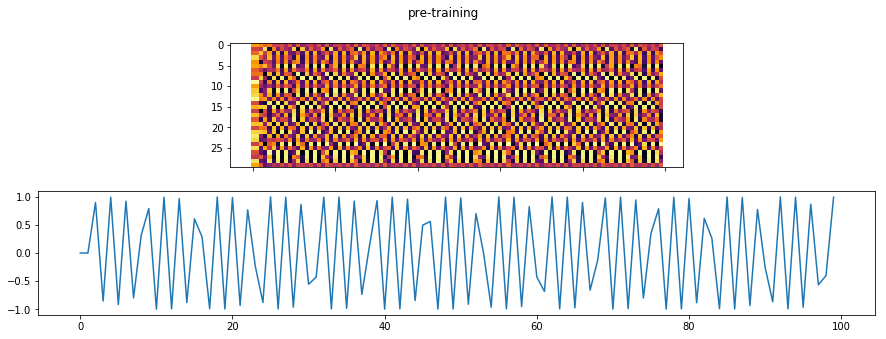

(100, 1)
(9900, 30)
(9900, 1)
Final MSE: 0.00014281278708949685


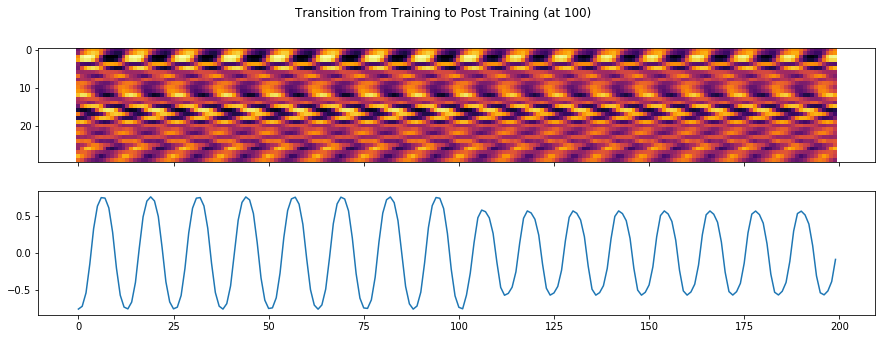

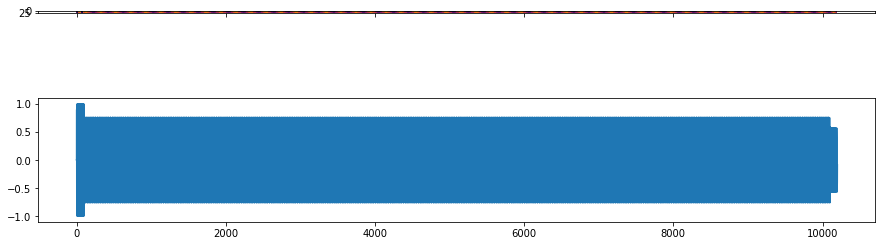

In [71]:
torch.manual_seed(1)

dt = 0.5
warmup_steps = 100
train_steps = 10000

# Initialize network
net = ESN(n=30,p=.3,g=.9,in_scale=1,fb_scale=1,noise_scale=0)

# Let the network warmup
net.run(warmup_steps)

net.plot_history(start=0,end=warmup_steps,title='pre-training')


# Start forcing output to be teacher signal
for train_step in range(train_steps):
    net.y = net.nl(torch.sin(torch.tensor([train_step*dt])))
    net.forward(u = torch.tensor([0.0]))

net.y = net.nl(torch.sin(torch.tensor([(train_step+1)*dt])))


# Train readout weights on that epoch
epochs = 2000
lr = 0.01

train_start = warmup_steps+100
train_end = warmup_steps+train_steps

states = torch.tensor(net.x_agg[train_start:train_end]).detach().numpy()
targets = torch.tensor(net.y_agg[train_start:train_end]).detach().numpy()

w_out = (net.w_out).clone().detach().numpy()

statesinv = np.linalg.pinv(states)
print(w_inv.shape)
print(states.shape)
print(targets.shape)

new_w = np.dot(statesinv,targets)
w_out = torch.tensor(new_w)


net.w_out = w_out

net_out = torch.matmul(torch.tensor(states),w_out)
diff = net_out - torch.tensor(targets)
sq_err = diff.pow(2)

mse = torch.sum(sq_err) / train_steps
print('Final MSE: {}'.format(mse.data))
    
net.run(100)

net.plot_history(start=(train_end-100),end=(train_end+100),title='Transition from Training to Post Training (at 100)') 
net.plot_history()

### It doesn't do any better than gradient descent, so the problem really lies in timescales that the network can solve (which can be fixed by adding a separate step_dt term to the forward function, as in force repo), and sensitivity to hyperparameters. All of these are presumably moot when we move into a regime where we use backprop through time.